# Middleware Project: Big Data

## Initialization

In [1]:
DATASET_DIR = './dataset/'

#### Imports

In [14]:
# ignore library future deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# imports
import operator
import pyspark
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from time import time
from datetime import datetime, date

#### Initialize Spark

In [3]:
sc = pyspark.SparkContext("local[4]", "MiddlewareProject")  # 4 threads
spark = SparkSession.builder.appName("MiddlewareProject").getOrCreate()

#### Load datasets

In [4]:
years = range(1994, 2009)
# years = range(2004, 2005)
path = DATASET_DIR + '{' + ','.join(str(y) for y in years) + '}.csv'
print('Loading from:', path)

df = spark.read.csv(path, header=True)
print('Number of entries:', df.count())

Loading from: ./dataset/{1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008}.csv
Number of entries: 91469371


#### Prepare datasets for queries

In [5]:
# replace 'NA' with null values
df = df.replace('NA', None)

In [6]:
# cast columns to the correct type
intcolumns = ['Year', 'Month', 'DayofMonth', 'DayofWeek', 'DepTime', 'CRSDEPTime', 'ArrTime', 'CRSArrTime',
              'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'CarrierDelay',
              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'Diverted']

for c in intcolumns:
    df = df.withColumn(c, df[c].cast('int'))
df.first()

Row(Year=2002, Month=1, DayofMonth=13, DayofWeek=7, DepTime=2231, CRSDEPTime=2235, ArrTime=2342, CRSArrTime=2353, UniqueCarrier='US', FlightNum='723', TailNum='N709��', ActualElapsedTime=71, CRSElapsedTime=78, AirTime=55, ArrDelay=-11, DepDelay=-4, Origin='PIT', Dest='CLT', Distance=366, TaxiIn='3', TaxiOut='13', Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None)

## Utils

In [7]:
def date_from_isoweek(iso_year, iso_weeknumber, iso_weekday):
    return datetime.strptime(
        '{:04d} {:02d} {:d}'.format(iso_year, iso_weeknumber, iso_weekday), '%G %V %u')

In [18]:
# add the week as key
def find_week(row):
    '''Returns the week as a tuple (year, week in the year)'''
    d = datetime(year=row['Year'], month=row['Month'], day=row['DayofMonth'])
    ic = d.isocalendar()
    return (ic[0], ic[1])

## Percentage of canceled flights per day

### Query

In [8]:
# get RDD
raw_data = df.rdd

#total flight per day
indexed_by_day = raw_data.map(lambda m: ((m['Year'], m['Month'], m['DayofMonth']),(m['Cancelled'],1)))
num_flights_day = indexed_by_day.reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1]))

#compute percentage per day
starttime = time()
#compute average
daily_percentage = num_flights_day.map(lambda m: (m[0],m[1][0]*100.0/m[1][1]))
res = daily_percentage.map(lambda m: m[1]).reduce(lambda a,b: a+b)/daily_percentage.count()
result = daily_percentage.collect()
endtime = time() - starttime
print('Time taken: {:.2f} seconds'.format(endtime))

Time taken: 893.73 seconds


### Results

In [9]:
print("Daily average percentage of cancelled flights: ", res)
result = sorted(result, key=lambda s: s[0])
# print("Percentage of cancelled flights per day: ", result)
for (year, month, day), ratio in result:
    d = date(year, month, day)
    print("{}: {:5.2f}%".format(datetime.strftime(d, "%Y-%m-%d"), ratio))

Daily average percentage of cancelled flights:  2.127927917735455
1994-01-01:  0.53%
1994-01-02:  0.45%
1994-01-03:  1.54%
1994-01-04: 15.56%
1994-01-05:  4.77%
1994-01-06:  5.42%
1994-01-07:  8.75%
1994-01-08:  9.57%
1994-01-09:  1.11%
1994-01-10:  1.85%
1994-01-11:  1.37%
1994-01-12:  7.87%
1994-01-13:  2.24%
1994-01-14:  1.50%
1994-01-15:  1.20%
1994-01-16:  4.79%
1994-01-17: 17.11%
1994-01-18: 11.71%
1994-01-19:  7.06%
1994-01-20:  3.11%
1994-01-21:  1.33%
1994-01-22:  0.95%
1994-01-23:  1.13%
1994-01-24:  1.86%
1994-01-25:  4.03%
1994-01-26:  5.95%
1994-01-27: 11.58%
1994-01-28:  6.98%
1994-01-29:  4.33%
1994-01-30:  2.53%
1994-01-31:  1.02%
1994-02-01:  0.66%
1994-02-02:  0.59%
1994-02-03:  0.72%
1994-02-04:  0.47%
1994-02-05:  0.68%
1994-02-06:  0.59%
1994-02-07:  1.51%
1994-02-08: 21.35%
1994-02-09: 14.13%
1994-02-10:  8.76%
1994-02-11: 25.62%
1994-02-12:  7.44%
1994-02-13:  2.75%
1994-02-14:  0.94%
1994-02-15:  0.30%
1994-02-16:  0.36%
1994-02-17:  0.39%
1994-02-18:  0.21%
199

2000-08-24:  2.23%
2000-08-25:  1.72%
2000-08-26:  1.80%
2000-08-27:  2.03%
2000-08-28:  2.49%
2000-08-29:  2.60%
2000-08-30:  2.01%
2000-08-31:  2.12%
2000-09-01:  1.70%
2000-09-02:  1.35%
2000-09-03:  1.59%
2000-09-04:  1.50%
2000-09-05:  1.50%
2000-09-06:  1.99%
2000-09-07:  1.72%
2000-09-08:  1.41%
2000-09-09:  1.80%
2000-09-10:  1.57%
2000-09-11:  7.25%
2000-09-12:  5.45%
2000-09-13:  2.29%
2000-09-14:  1.60%
2000-09-15:  1.55%
2000-09-16:  1.99%
2000-09-17:  2.32%
2000-09-18:  2.20%
2000-09-19:  3.28%
2000-09-20:  2.02%
2000-09-21:  2.03%
2000-09-22:  2.93%
2000-09-23:  2.61%
2000-09-24:  1.18%
2000-09-25:  1.83%
2000-09-26:  3.08%
2000-09-27:  1.71%
2000-09-28:  1.78%
2000-09-29:  1.54%
2000-09-30:  1.91%
2000-10-01:  1.39%
2000-10-02:  2.34%
2000-10-03:  2.47%
2000-10-04:  3.25%
2000-10-05:  2.28%
2000-10-06:  2.31%
2000-10-07:  1.89%
2000-10-08:  1.39%
2000-10-09:  2.03%
2000-10-10:  2.17%
2000-10-11:  2.13%
2000-10-12:  1.53%
2000-10-13:  1.19%
2000-10-14:  1.35%
2000-10-15: 

### Analysis

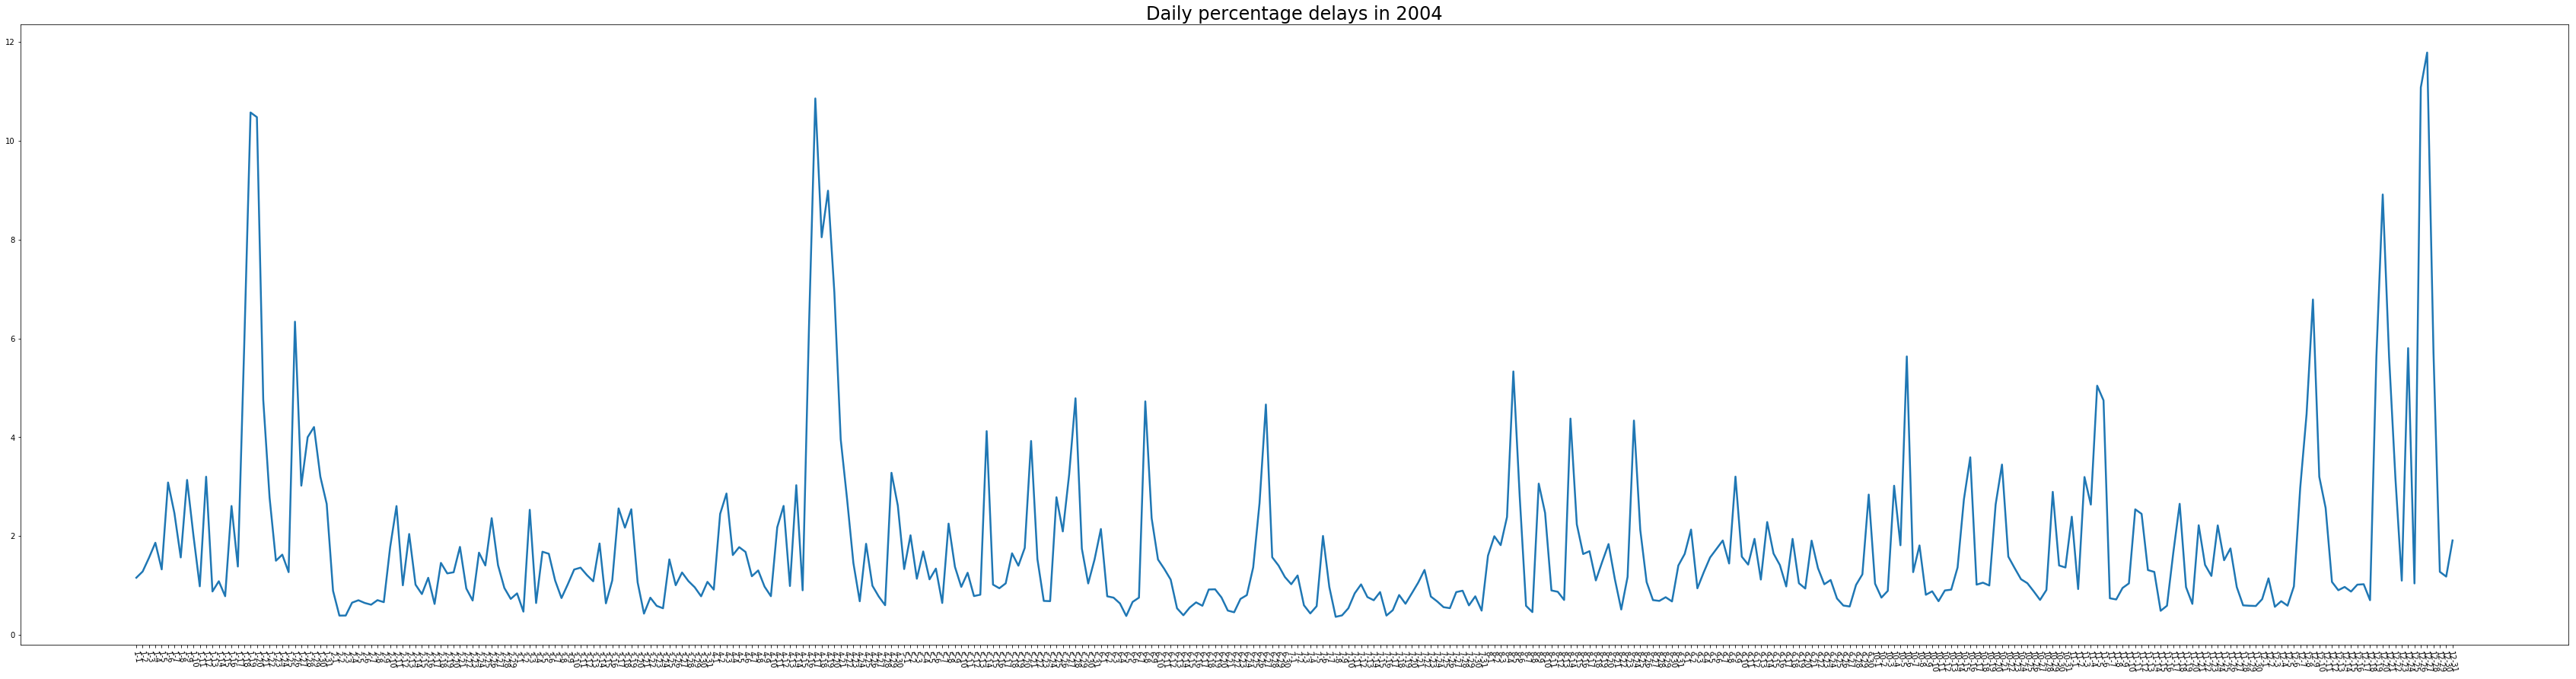

In [10]:
# day
x = [str(m[0][1])+'-'+str(m[0][2]) for m in result if m[0][0]==2004]
y = [m[1] for m in result if m[0][0]==2004]
import seaborn as sns
ax = sns.lineplot(x=x, y=y, palette="deep", linewidth=2.5)
ax.set_title('Daily percentage delays in 2004')
ax.title.set_fontsize(24)
ax.set_xticklabels(x, rotation=280)
ax.figure.set_size_inches(60,15)

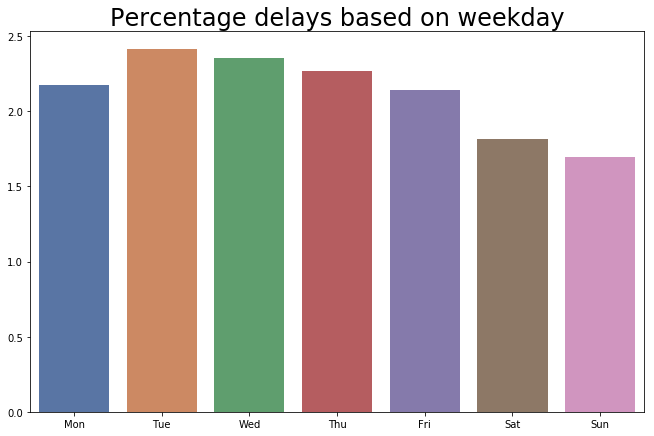

In [11]:
# weekday
weekday_percentage = num_flights_day.map(lambda m: (date(m[0][0],m[0][1],m[0][2]).weekday(), m[1])).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).map(lambda m: (m[0], m[1][0]*100.0/m[1][1]))
weekday_percentage_arr = sorted(weekday_percentage.collect())

x = [str(m[0]) for m in weekday_percentage_arr]
y = [m[1] for m in weekday_percentage_arr]
ax = sns.barplot(x=x, y=y, palette="deep")
ax.set_title('Percentage delays based on weekday')
ax.title.set_fontsize(24)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.figure.set_size_inches(11,7)

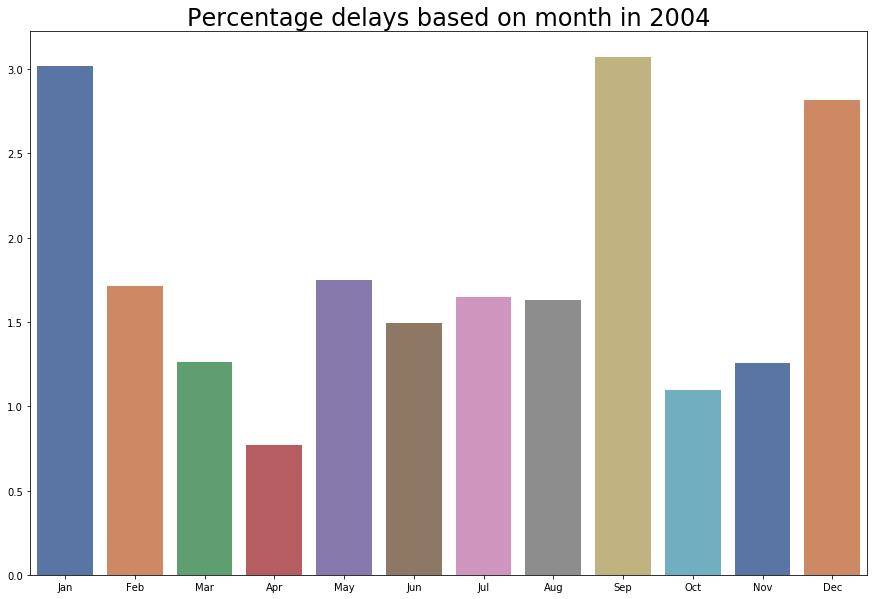

In [12]:
# month
monthly_percentage = num_flights_day.map(lambda m: ((m[0][0],m[0][1]),(m[1][0],m[1][1]))).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).map(lambda m: (m[0], m[1][0]*100.0/m[1][1]))
monthly_percentage_arr = sorted(monthly_percentage.collect())

x = [m[0][1] for m in monthly_percentage_arr if m[0][0]==2004]
y = [m[1] for m in monthly_percentage_arr if m[0][0]==2004]
ax = sns.barplot(x=x, y=y, palette="deep")
ax.set_title('Percentage delays based on month in 2004')
ax.title.set_fontsize(24)
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'))
ax.figure.set_size_inches(15,10)

,x,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
0,1,4.858904,3.067324,6.617489,3.951447,3.070790,5.848872,5.210669,3.753444,1.673252,1.510752,3.015649,4.216337,1.683678,2.538295,2.857214
1,2,4.374422,2.379564,3.470905,2.072146,2.539532,3.477505,3.416881,3.651554,1.082008,3.998553,1.711755,1.742975,2.125753,4.502267,3.618183
2,3,1.195593,1.593056,1.984790,1.810684,2.142035,2.663495,2.119707,3.365724,1.346964,1.708078,1.264192,1.646695,1.253435,2.640294,2.626727
3,4,0.586468,1.324268,1.266493,1.577039,1.570562,1.980161,2.513043,2.219815,1.030034,1.201207,0.769336,1.266964,1.128212,1.812094,1.731241
4,5,0.384940,1.431277,1.569089,1.132366,2.090618,2.566150,3.448045,1.783598,0.987010,0.808008,1.746300,0.955918,1.170472,1.083107,1.027391
5,6,0.629558,1.319913,1.809790,1.505312,2.882890,2.752857,3.954999,2.981181,1.709890,0.775588,1.493906,1.627722,1.686068,2.740116,1.795898
6,7,0.859069,1.294414,2.039810,1.689694,2.017607,3.137453,3.212218,2.096055,1.344580,1.402694,1.649717,2.205710,1.727984,2.082460,1.687765
7,8,0.538035,1.663231,1.719252,1.484329,3.160696,2.442086,3.050883,2.446583,1.143833,1.635415,1.631020,2.132179,1.555989,1.882044,1.606294
8,9,0.405467,1.162937,1.761142,1.429918,7.409986,3.311889,2.238192,20.241370,0.857217,1.457418,3.070968,2.008174,1.701038,1.084162,1.832659
9,10,0.487795,1.091700,1.740561,1.640294,1.706503,2.038704,2.134589,1.543502,1.018608,0.921665,1.097474,1.767300,1.863440,1.163031,0.584137


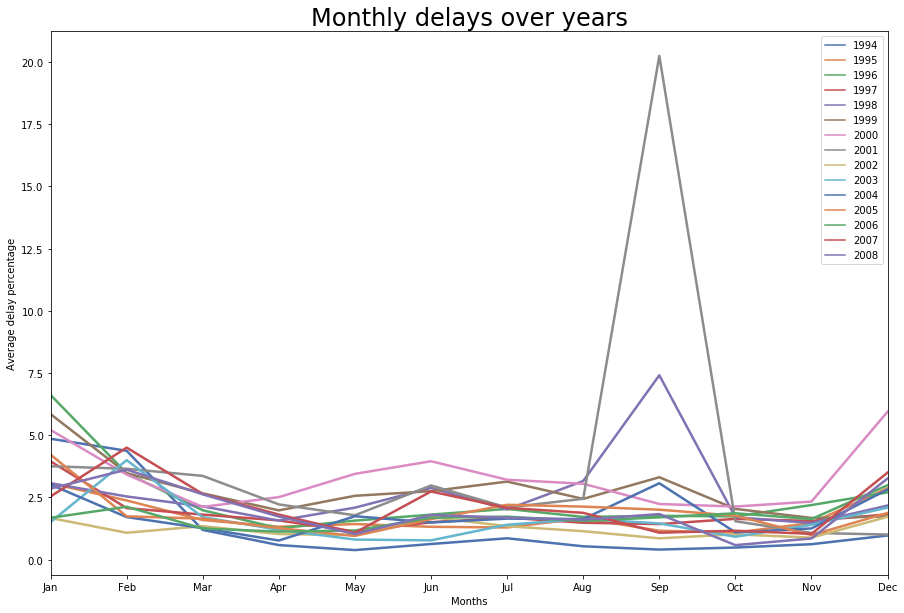

In [16]:
graph_df=pd.DataFrame({'x': range(1,13)})
for year in range(1994, 2009):
    graph_df[str(year)] = [m[1] for m in monthly_percentage_arr if m[0][0]==year]
    
ax = sns.lineplot(data=graph_df, palette="deep", dashes=False,linewidth=2.5)
ax.set_title('Monthly delays over years')
ax.title.set_fontsize(24)
ax.figure.set_size_inches(15,10)
ax.set_xlabel('Months')
ax.set_ylabel('Average delay percentage')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(('Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'))
ax.set_xlim(0,11)
graph_df

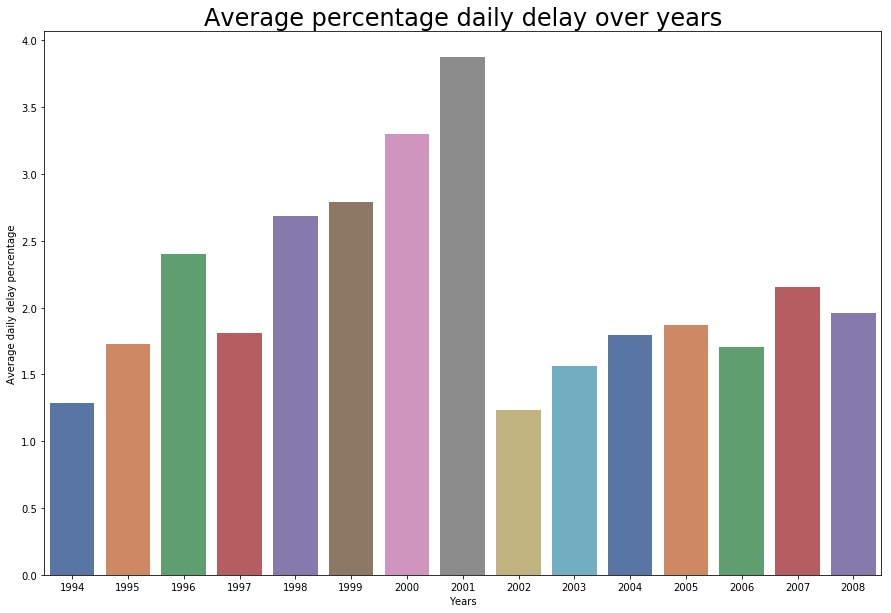

In [17]:
# years
yearly_percentage = num_flights_day.map(lambda m: ((m[0][0],(m[1][0],m[1][1])))).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).map(lambda m: (m[0], m[1][0]*100.0/m[1][1]))
yearly_percentage_arr = sorted(yearly_percentage.collect())

x = [str(y[0]) for y in yearly_percentage_arr]
y = [y[1] for y in yearly_percentage_arr]
ax = sns.barplot(x=x, y=y, palette="deep")
ax.set_title('Average percentage daily delay over years')
ax.title.set_fontsize(24)
ax.set_xlabel('Years')
ax.set_ylabel('Average daily delay percentage')
ax.figure.set_size_inches(15,10)

## Weekly percentages of delays due to weather

We want to find the amount of delays that have been (at least partially) caused by the weather.

Our target metric can be computed as 
\begin{equation*}\frac{number\ of\ flights\ delayed\ by\ weather}{total\ number\ of\ delayed\ flights}\end{equation*}

### Query

In [9]:
# get RDD
raw_data = df.rdd

# filter out flights with no arrival delay
delayed_flights = raw_data.filter(lambda r: r['ArrDelay'] is not None and r['ArrDelay'] > 0)

# add the week as key
# ((year, week), row)
def find_week(row):
    '''Returns the week as a tuple (year, week in the year)'''
    d = datetime(year=row['Year'], month=row['Month'], day=row['DayofMonth'])
    ic = d.isocalendar()
    return (ic[0], ic[1])

indexed_by_week = delayed_flights.map(lambda r: (find_week(r), r))

# check for each flight if it had any weather delay
# also map to 1 to count delayed flights
# ((year, week), (1, delayed by weather))
flight_delays = indexed_by_week.map(lambda t: (t[0], (1, 1 if t[1]['WeatherDelay'] else 0)))

# count number flights with delay and number of flights with weather delay, for each week
# ((year, week), (number of delayed flights, number of flights delayed by weather))
num_delays = flight_delays.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# compute percentage of weather delays over all delayed flights, for each week
# ((year, week), percentage of delays due to weather)
weather_delay_ratios = num_delays.map(lambda t: (t[0], 100 * t[1][1] / t[1][0]))

In [10]:
# execute query
starttime = time()
weather_result = weather_delay_ratios.collect()
endtime = time() - starttime
print('Time taken: {:.2f} seconds'.format(endtime))

Time taken: 750.45 seconds


### Results

In [11]:
# order in cronological order
weather_result = sorted(weather_result, key=lambda x: (x[0][0], x[0][1]))

In [12]:
# show sample results for 2004
print("-- Year 2004 --")
for (year, week), ratio in weather_result:
    if year == 2004:
        d = date_from_isoweek(year, week, 1)
        print("{}: {:5.2f}%".format(datetime.strftime(d, "%Y-%m-%d"), ratio))

-- Year 2004 --
2003-12-29:  4.17%
2004-01-05:  4.54%
2004-01-12:  4.81%
2004-01-19:  3.59%
2004-01-26:  6.81%
2004-02-02:  5.50%
2004-02-09:  3.41%
2004-02-16:  1.80%
2004-02-23:  4.41%
2004-03-01:  3.36%
2004-03-08:  1.79%
2004-03-15:  3.58%
2004-03-22:  1.32%
2004-03-29:  1.76%
2004-04-05:  1.53%
2004-04-12:  2.80%
2004-04-19:  2.79%
2004-04-26:  3.09%
2004-05-03:  2.68%
2004-05-10:  5.17%
2004-05-17:  4.11%
2004-05-24:  3.99%
2004-05-31:  3.60%
2004-06-07:  5.49%
2004-06-14:  5.05%
2004-06-21:  6.58%
2004-06-28:  5.60%
2004-07-05:  3.89%
2004-07-12:  3.92%
2004-07-19:  3.26%
2004-07-26:  5.31%
2004-08-02:  2.98%
2004-08-09:  3.11%
2004-08-16:  4.94%
2004-08-23:  4.26%
2004-08-30:  2.31%
2004-09-06:  3.09%
2004-09-13:  2.97%
2004-09-20:  0.65%
2004-09-27:  2.50%
2004-10-04:  3.43%
2004-10-11:  1.21%
2004-10-18:  4.36%
2004-10-25:  3.32%
2004-11-01:  2.51%
2004-11-08:  2.33%
2004-11-15:  2.36%
2004-11-22:  7.88%
2004-11-29:  2.11%
2004-12-06:  4.43%
2004-12-13:  3.15%
2004-12-20:  7.

### Analysis

There is no data about weather delays before June 2003.

In [13]:
# find the first day with a weather delay > 0 and not NA

# get count of meaningful weather delays per day
delays_by_day = df.filter(df['WeatherDelay'] > 0).groupBy(['Year','Month','DayofMonth']).count().collect()

# sort cronologically
delays_by_day = sorted(delays_by_day, key=lambda r: (r.Year, r.Month, r.DayofMonth))

first_delay = datetime(delays_by_day[0].Year, delays_by_day[0].Month, delays_by_day[0].DayofMonth)
print("First available weather delay at {}".format(first_delay))

First available weather delay at 2003-06-01 00:00:00


### Delays due to weather by week

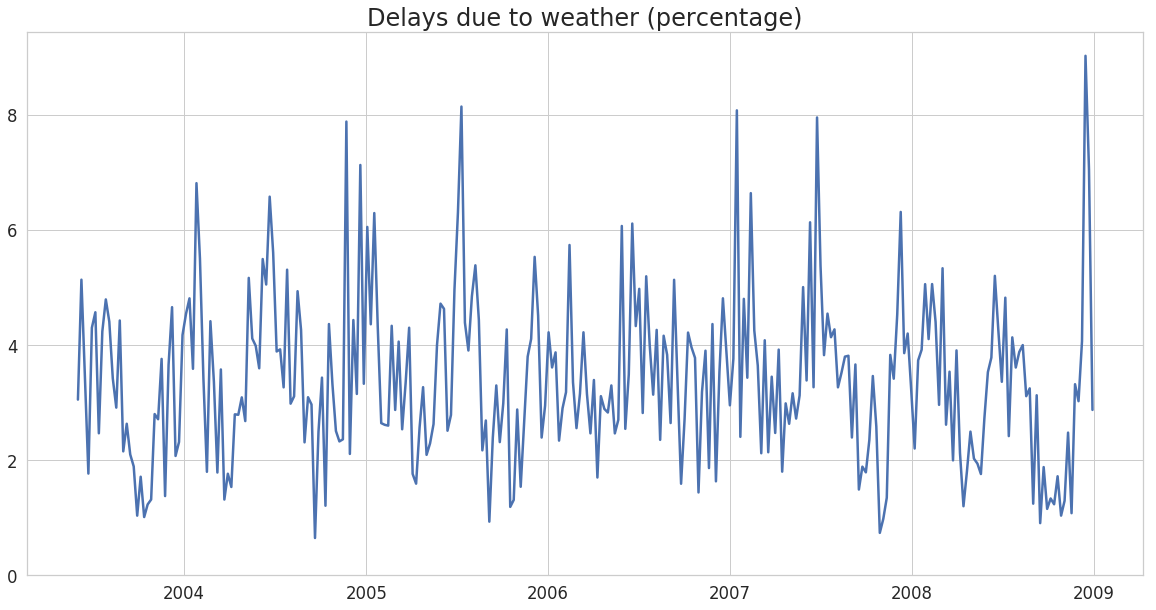

In [14]:
# plot percentages by week

ratios = [value for _, value in weather_result]
dates = [date_from_isoweek(year, week, 1) for (year, week), _ in weather_result]

data = pd.DataFrame(ratios, dates, columns=['Delays due to weather (percentage)'])
data = data[data.index >= first_delay]   # filter empty samples

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.lineplot(data=data, palette="deep", linewidth=2.5, legend=None)
ax.set_title('Delays due to weather (percentage)')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
ax.figure.set_size_inches(20, 10)

### Seasonal trends

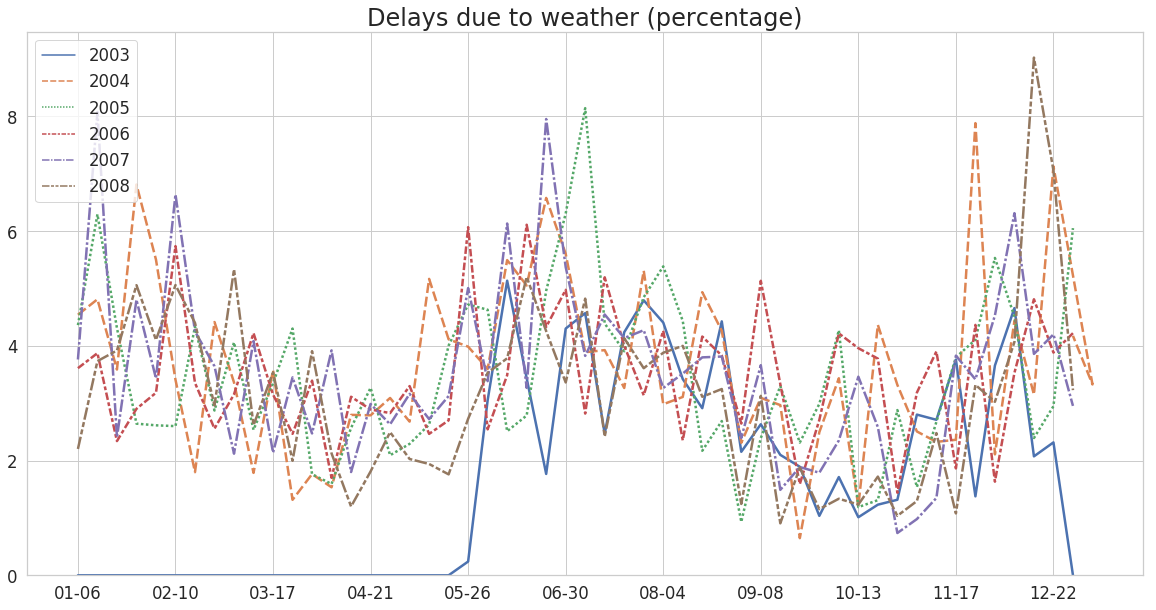

In [15]:
# plot different years overlapped over each others

ratios = [[value for (year, week), value in weather_result if year == y] for y in range(2003, 2009)]
ratios = [x for x in itertools.zip_longest(*ratios)]  # transpose
years = range(2003, 2009)
months = [datetime.strftime(date_from_isoweek(2003, w, 1), '%m-%d') for w in range(1, 54)]

data = pd.DataFrame(ratios, index=months, columns=years)

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.lineplot(data=data, palette="deep", linewidth=2.5)
ax.set_title('Delays due to weather (percentage)')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # reduce number of visible ticks
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(ax.get_xgridlines()):
    if ind % 5 == 0:  # reduce number of visible gridlines
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.figure.set_size_inches(20, 10)

## Delay reduced per distance group

We want to find the percentage of flights belonging to a given "distance group" that were able to halve their departure delays by the time they arrived at their destinations.

Distance groups assort flights by their total distance in miles, with steps of 200 miles.

For instance, flights with distances that are between 200 and 399 miles belong in group 2.

### Query

In [16]:
# get RDD
raw_data = df.rdd

# remove data with missing values
filtered_data = raw_data.filter(lambda r: r['DepDelay'] is not None
                                          and r['ArrDelay'] is not None
                                          and r['Distance'] is not None)

# take only flights with a departure delay
late_departures = filtered_data.filter(lambda r: r['DepDelay'] > 0)

# add distance group as key
# (group, row)
def distance_group(row):
    distance = row['Distance']
    return (distance // 200) + 1
    
distance_groups = late_departures.map(lambda r: (distance_group(r), r))

# check for each flight if it managed to halve its departure delay
# also map to 1 to count flights
# (group, (1, was_delay_halved))
def was_delay_halved(row):
    departure_delay = row['DepDelay']
    arrival_delay = row['ArrDelay']
    return arrival_delay <= departure_delay / 2

halved_delays = distance_groups.map(lambda t: (t[0], (1, was_delay_halved(t[1]))))

# count number of delayed flights and number of flights with halved delay
# (group, (number of delayed flights, flights with halved delay))
totals = halved_delays.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# compute percentage per distance group
# (group, percentage)
halving_percentages = totals.map(lambda t: (t[0], 100 * t[1][1] / t[1][0]))

In [17]:
# execute query
starttime = time()
distance_results = halving_percentages.collect()
endtime = time() - starttime
print('Time taken: {:.2f} seconds'.format(endtime))

Time taken: 837.36 seconds


### Results

In [18]:
# sort by distance group
distance_results = sorted(distance_results, key=lambda x: x[0])

In [19]:
# raw results
for group, percentage in distance_results:
    print("{:4} < d < {:4} miles --> {:.2f}%".format((group-1) * 200, group * 200, percentage))

   0 < d <  200 miles --> 26.64%
 200 < d <  400 miles --> 28.54%
 400 < d <  600 miles --> 31.27%
 600 < d <  800 miles --> 33.98%
 800 < d < 1000 miles --> 36.38%
1000 < d < 1200 miles --> 37.60%
1200 < d < 1400 miles --> 39.87%
1400 < d < 1600 miles --> 39.59%
1600 < d < 1800 miles --> 41.24%
1800 < d < 2000 miles --> 42.84%
2000 < d < 2200 miles --> 42.63%
2200 < d < 2400 miles --> 43.85%
2400 < d < 2600 miles --> 43.21%
2600 < d < 2800 miles --> 45.06%
2800 < d < 3000 miles --> 44.37%
3000 < d < 3200 miles --> 31.95%
3200 < d < 3400 miles --> 41.03%
3400 < d < 3600 miles --> 41.97%
3600 < d < 3800 miles --> 46.74%
3800 < d < 4000 miles --> 42.41%
4000 < d < 4200 miles --> 42.02%
4200 < d < 4400 miles --> 47.66%
4400 < d < 4600 miles --> 45.91%
4800 < d < 5000 miles --> 49.42%


### Analysis

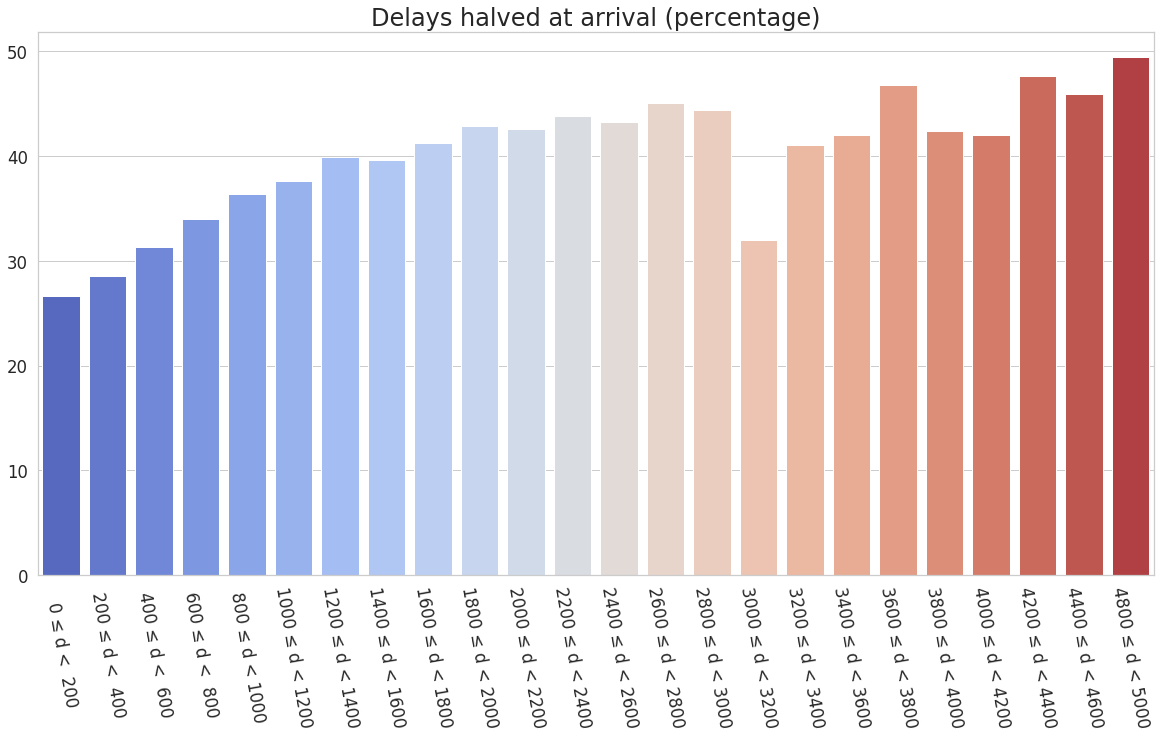

In [20]:
# plot percentage per distance group

values = [value for _, value in distance_results]
groups = ["{:4} ≤ d < {:4}".format((group-1) * 200, group * 200) for group, _ in distance_results]
pand_dict = dict((g, v) for g, v in zip(groups, values))

data = pd.DataFrame(data=pand_dict, index=range(24))

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.barplot(data=data, palette="coolwarm")
ax.set_title('Delays halved at arrival (percentage)')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=280)
ax.figure.set_size_inches(20, 10)

In [21]:
# number of flights per distance group

# query
num_per_group = distance_groups.countByKey()

# results
for group in range(1, max(num_per_group) + 1):
    print("{:4} < d < {:4} miles --> {:7}%".format((group-1) * 200, group * 200, num_per_group[group]))

   0 < d <  200 miles --> 2836466%
 200 < d <  400 miles --> 8815673%
 400 < d <  600 miles --> 6450395%
 600 < d <  800 miles --> 4821451%
 800 < d < 1000 miles --> 4175954%
1000 < d < 1200 miles --> 2728251%
1200 < d < 1400 miles --> 1199318%
1400 < d < 1600 miles --> 1469301%
1600 < d < 1800 miles --> 1083416%
1800 < d < 2000 miles -->  724233%
2000 < d < 2200 miles -->  520285%
2200 < d < 2400 miles -->  414374%
2400 < d < 2600 miles -->  672037%
2600 < d < 2800 miles -->  110869%
2800 < d < 3000 miles -->   18298%
3000 < d < 3200 miles -->    1180%
3200 < d < 3400 miles -->    4640%
3400 < d < 3600 miles -->    1246%
3600 < d < 3800 miles -->   12251%
3800 < d < 4000 miles -->    9380%
4000 < d < 4200 miles -->    5226%
4200 < d < 4400 miles -->    8074%
4400 < d < 4600 miles -->    7229%
4600 < d < 4800 miles -->       0%
4800 < d < 5000 miles -->    2843%


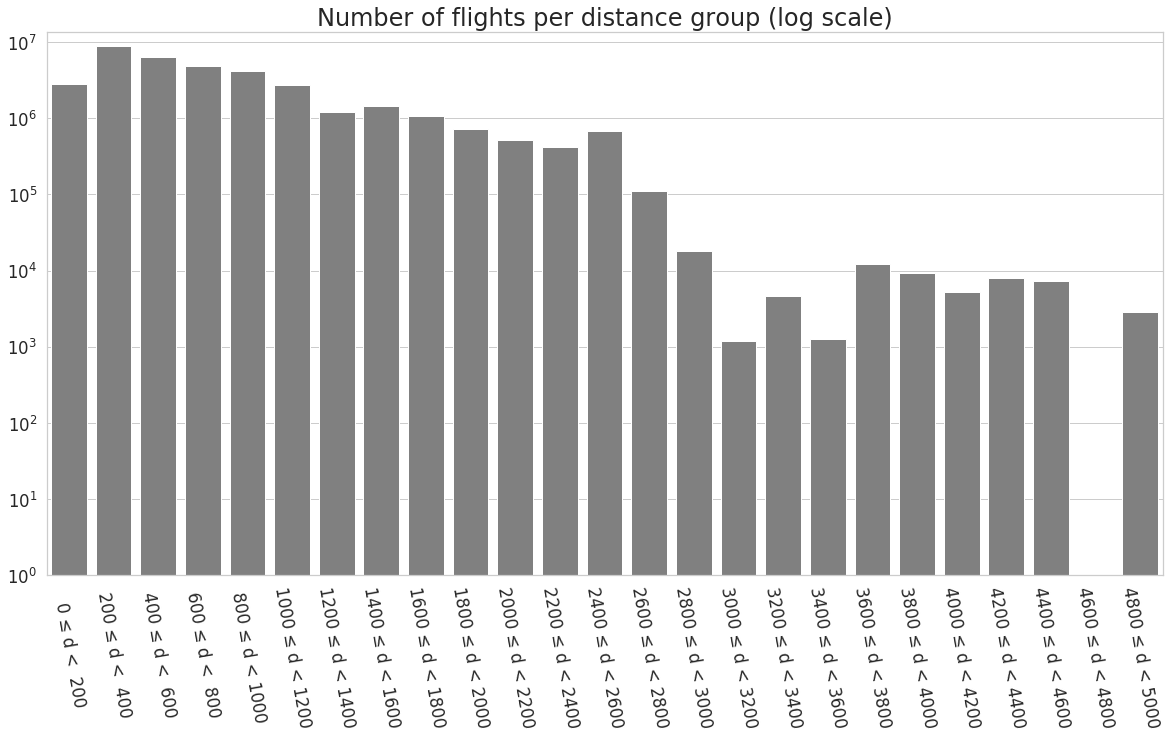

In [22]:
# plot number of flights per distance group
groups_sorted = sorted([(group, num_per_group[group]) for group in num_per_group])

values = [value for _, value in groups_sorted]
groups = ["{:4} ≤ d < {:4}".format((group-1) * 200, group * 200) for group, _ in groups_sorted]
pand_dict = dict((g, v) for g, v in zip(groups, values))

data = pd.DataFrame(data=pand_dict, index=range(25))

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.barplot(data=data, color='gray')
ax.set_title('Number of flights per distance group (log scale)')
ax.title.set_fontsize(24)
ax.set(yscale="log")
ax.set_ylim(1, None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=280)
ax.figure.set_size_inches(20, 10)

## Airport penalty scores

A weekly "penalty" score for each airport that depends on both its incoming and outgoing flights. 
The score adds 
- 0.5 for each incoming flight that is more than 15 minutes late
- 1 for each outgoing flight that is more than 15 minutes late

### Query

In [19]:
def dep_penalty(row):
    res = (row['Origin'], 1, 0, 0)
    if(row['DepDelay'] is not None and row['DepDelay'] > 15):
        res =  (row['Origin'], 1, 0,1)
    return res
    
def arr_penalty(row):
    res = (row['Dest'], 0, 1,0)
    if(row['ArrDelay'] is not None and row['ArrDelay'] > 15):
        res = (row['Dest'], 0, 1,0.5)
    return res

In [20]:
# Get RDD
airports_with_delays = df.rdd

# add the week as key
def find_week(row):
    '''Returns the week as a tuple (year, week in the year)'''
    d = datetime(year=row['Year'], month=row['Month'], day=row['DayofMonth'])
    ic = d.isocalendar()
    return (ic[0], ic[1])

# add week number 
indexed_by_week = airports_with_delays.map(lambda r: (find_week(r), r))

final = indexed_by_week.flatMap(lambda m: ((m[0],dep_penalty(m[1])),(m[0],arr_penalty(m[1]))))
final = final.map(lambda m: ((m[0][0],m[0][1],m[1][0]),(m[1][1], m[1][2], m[1][3])))
final = final.reduceByKey(lambda a,b:( a[0]+b[0],a[1]+b[1],a[2]+b[2]))

# execute query
starttime = time()
weekly_pen = final.collect()
endtime = time() - starttime
print('Time taken: {:.2f} seconds'.format(endtime))

Time taken: 1316.10 seconds


### Results

In [21]:
# sort by week
weekly_pen = sorted(weekly_pen, key=lambda x: x[0])
weekly_pen

[((1993, 52, 'ABE'), (38, 35, 6.0)),
 ((1993, 52, 'ABQ'), (164, 165, 17.0)),
 ((1993, 52, 'ACY'), (4, 4, 0)),
 ((1993, 52, 'ADQ'), (1, 1, 0)),
 ((1993, 52, 'AGS'), (20, 20, 5.5)),
 ((1993, 52, 'AKN'), (1, 1, 0)),
 ((1993, 52, 'ALB'), (66, 60, 12.0)),
 ((1993, 52, 'AMA'), (19, 19, 4.5)),
 ((1993, 52, 'ANC'), (67, 63, 17.5)),
 ((1993, 52, 'ANI'), (1, 1, 0)),
 ((1993, 52, 'ATL'), (1221, 1222, 377.5)),
 ((1993, 52, 'AUS'), (148, 143, 24.5)),
 ((1993, 52, 'AVL'), (16, 16, 2)),
 ((1993, 52, 'AVP'), (13, 13, 5.0)),
 ((1993, 52, 'AZO'), (13, 13, 1.0)),
 ((1993, 52, 'BDL'), (136, 139, 26.0)),
 ((1993, 52, 'BET'), (2, 2, 0)),
 ((1993, 52, 'BFL'), (2, 1, 1)),
 ((1993, 52, 'BGM'), (8, 7, 2.5)),
 ((1993, 52, 'BGR'), (10, 10, 0.5)),
 ((1993, 52, 'BHM'), (81, 80, 16.0)),
 ((1993, 52, 'BIL'), (23, 23, 5.0)),
 ((1993, 52, 'BIS'), (8, 8, 1.5)),
 ((1993, 52, 'BNA'), (281, 275, 32.0)),
 ((1993, 52, 'BOI'), (29, 30, 9.0)),
 ((1993, 52, 'BOS'), (508, 509, 92.5)),
 ((1993, 52, 'BQN'), (4, 4, 0)),
 ((1993, 52

In [22]:
# sort by airport
sorted(weekly_pen, key=lambda x: x[0][2])

[((1993, 52, 'ABE'), (38, 35, 6.0)),
 ((1994, 1, 'ABE'), (142, 139, 36.0)),
 ((1994, 2, 'ABE'), (135, 130, 26.5)),
 ((1994, 3, 'ABE'), (132, 131, 36.5)),
 ((1994, 4, 'ABE'), (138, 135, 43.0)),
 ((1994, 5, 'ABE'), (140, 139, 16.5)),
 ((1994, 6, 'ABE'), (137, 134, 31.0)),
 ((1994, 7, 'ABE'), (138, 135, 18.0)),
 ((1994, 8, 'ABE'), (136, 136, 43.5)),
 ((1994, 9, 'ABE'), (133, 131, 21.5)),
 ((1994, 10, 'ABE'), (134, 132, 16.0)),
 ((1994, 11, 'ABE'), (130, 130, 16.0)),
 ((1994, 12, 'ABE'), (130, 127, 15.5)),
 ((1994, 13, 'ABE'), (131, 129, 7.0)),
 ((1994, 14, 'ABE'), (132, 131, 10.0)),
 ((1994, 15, 'ABE'), (132, 128, 23.0)),
 ((1994, 16, 'ABE'), (135, 135, 1.5)),
 ((1994, 17, 'ABE'), (135, 131, 19.0)),
 ((1994, 18, 'ABE'), (131, 129, 7.5)),
 ((1994, 19, 'ABE'), (133, 131, 14.0)),
 ((1994, 20, 'ABE'), (133, 132, 14.5)),
 ((1994, 21, 'ABE'), (129, 128, 13.5)),
 ((1994, 22, 'ABE'), (133, 137, 7.0)),
 ((1994, 23, 'ABE'), (135, 134, 19.0)),
 ((1994, 24, 'ABE'), (132, 129, 26.5)),
 ((1994, 25, 'AB

### Analysis

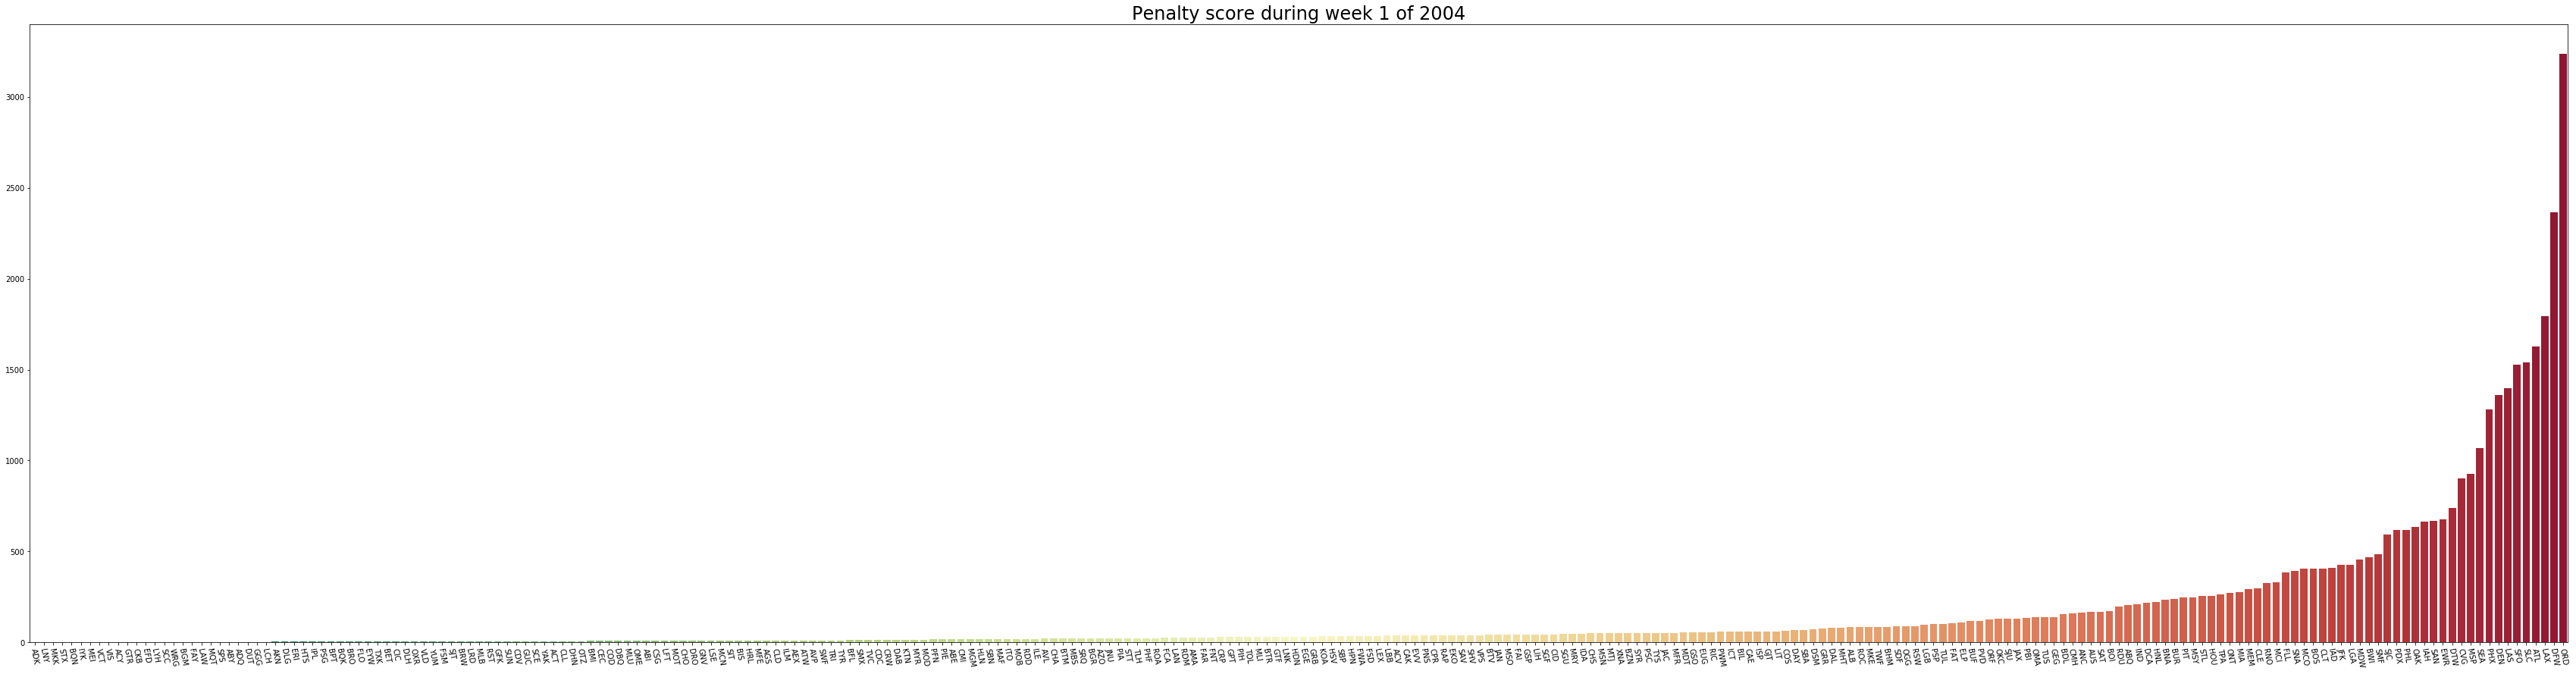

In [23]:
# Week 1 of 2004 example graph
x = [p[0][2] for p in sorted(weekly_pen, key=lambda x: x[1][2]) if (p[0][0]==2004 and p[0][1]==1)]
y = [p[1][2] for p in sorted(weekly_pen, key=lambda x: x[1][2]) if (p[0][0]==2004 and p[0][1]==1)]
ax = sns.barplot(x=x, y=y, palette="RdYlGn_r")
ax.set_title('Penalty score during week 1 of 2004')
ax.title.set_fontsize(24)
ax.set_xticklabels(x, rotation=280)
ax.figure.set_size_inches(60,15)

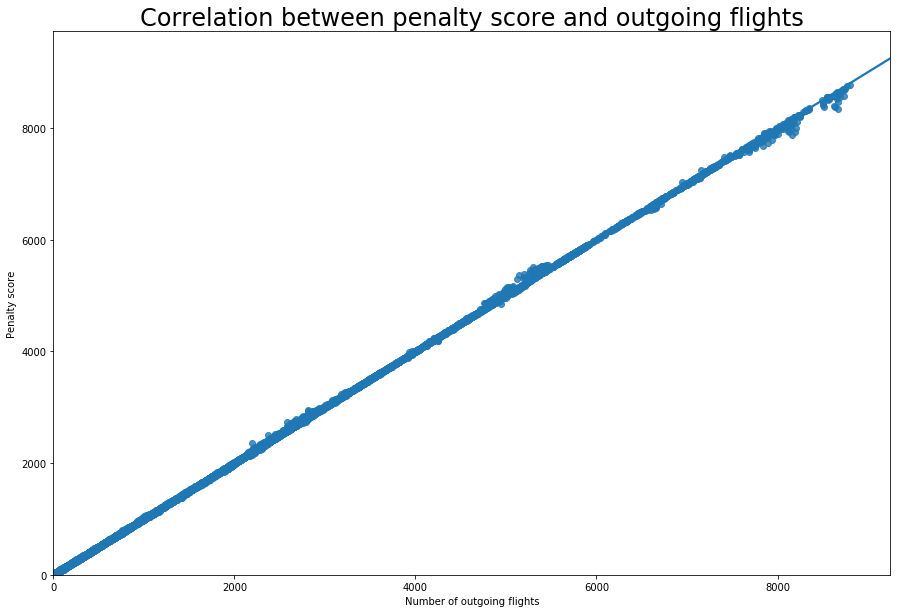

In [24]:
# penalty score over outgoing flights
x = [p[1][0] for p in weekly_pen]
y = [p[1][1] for p in weekly_pen]
ax = sns.regplot(x=x, y=y)
ax.set_title('Correlation between penalty score and outgoing flights')
ax.title.set_fontsize(24)
ax.set_xlabel('Number of outgoing flights')
ax.set_ylabel('Penalty score')
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.figure.set_size_inches(15,10)

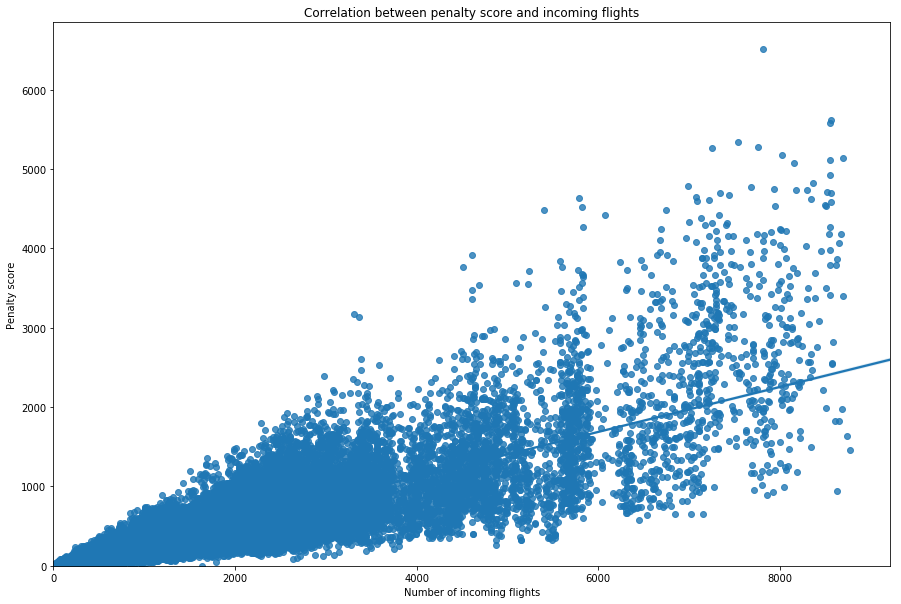

In [25]:
# penalty score over incoming flights
x = [y[1][1] for y in weekly_pen]
y = [y[1][2] for y in weekly_pen]
ax = sns.regplot(x=x, y=y)
ax.set_title('Correlation between penalty score and incoming flights')
ax.set_xlabel('Number of incoming flights')
ax.set_ylabel('Penalty score')
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.figure.set_size_inches(15,10)

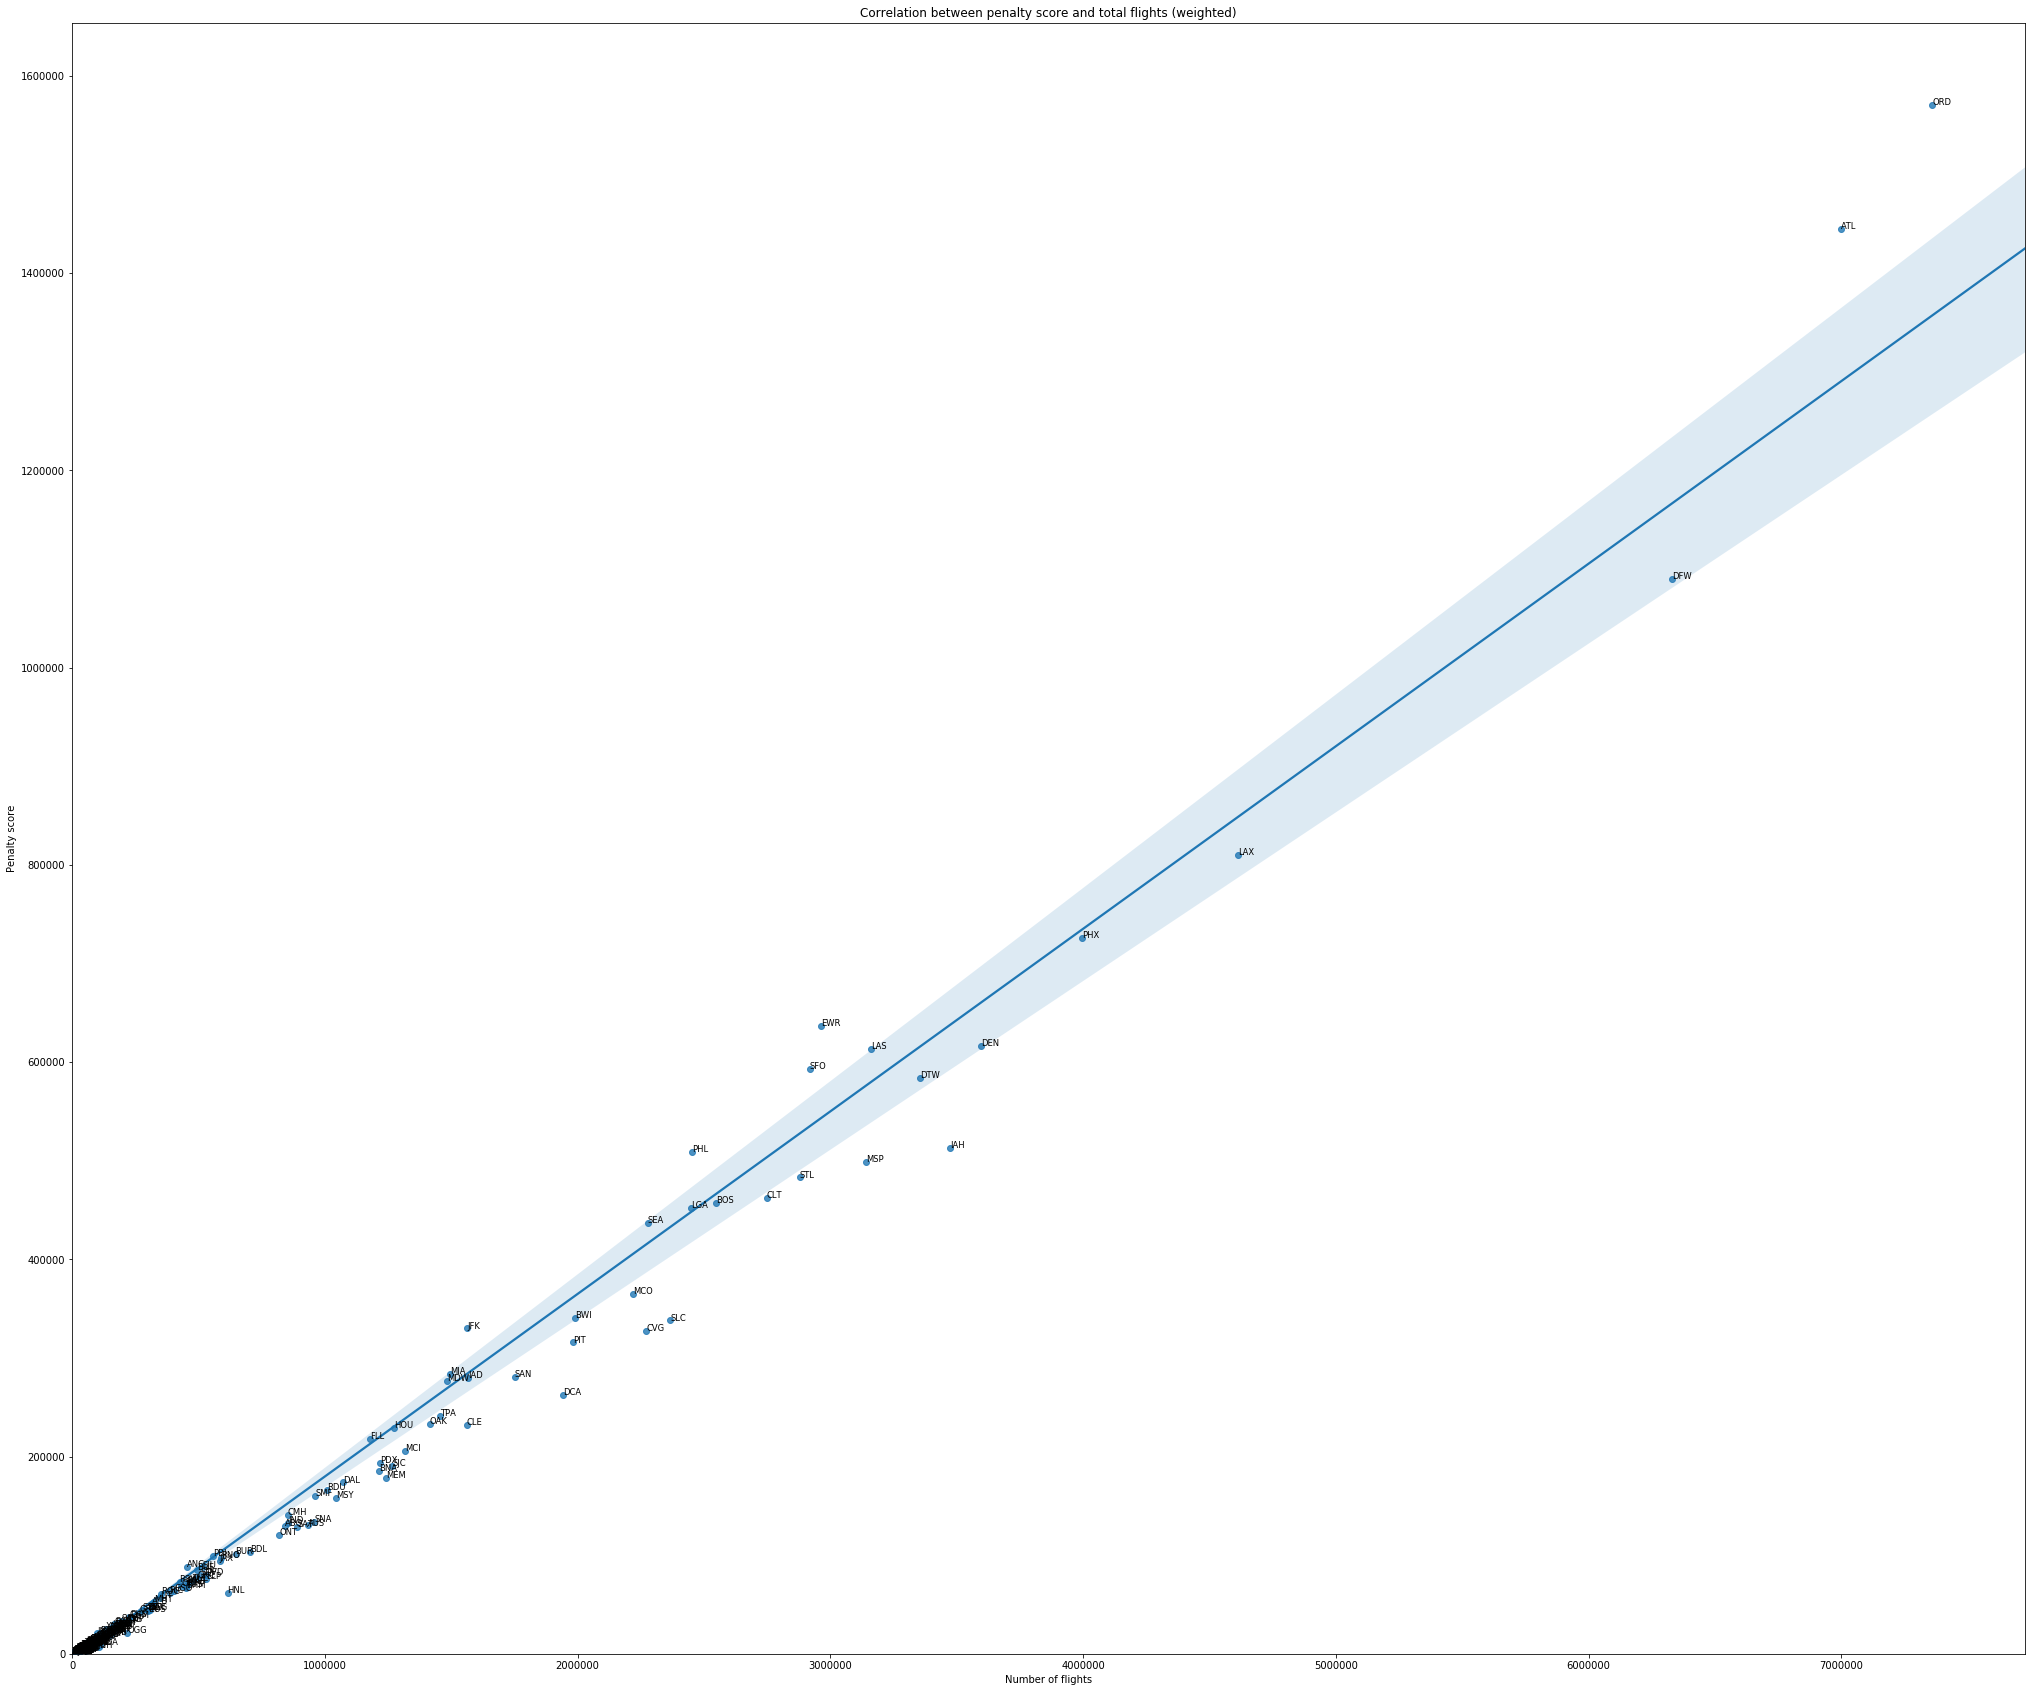

In [26]:
data = final.map(lambda m: ((m[0][2]),(m[1][0],m[1][1],m[1][2]))).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2])).collect()

# penalty score over total number of flights
data = pd.DataFrame({'Number of flights': [(y[1][0]+0.5*y[1][1]) for y in data],
                     'Penalty score': [y[1][2] for y in data],
                     'labels': [a[0] for a in data]})
ax = sns.regplot(data=data, x='Number of flights', y='Penalty score')
ax.set_title('Correlation between penalty score and total flights (weighted)')
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.figure.set_size_inches(35,30)

# add annotations one by one with a loop
for line in range(0, data.shape[0]):
     ax.text(data['Number of flights'][line]+5, data['Penalty score'][line]+0.05, data.labels[line], horizontalalignment='left', size='small', color='black')

## Our data analysis: carrier delays

We want to find out which carriers have the highest and lowest carrier delays on average.

Our target metric can be computed, for each carrier, as 
\begin{equation*}\frac{total\ minutes\ of\ carrier\ delay\ for\ the\ carrier}{total\ number\ of\ flights\ for \ the\ carrier}\end{equation*}

### Preprocessing

Data for carrier delays is not available until 2003. We'll consider only data after that date to avoid wrong results (i.e. older carriers would have a smaller average delay).

In [24]:
# find the first day with a carrier delay > 0 and not NA

# get count of meaningful carrier delays per day
delays_by_day = df.filter(df['CarrierDelay'] > 0).groupBy(['Year','Month','DayofMonth']).count().collect()

# sort cronologically
delays_by_day = sorted(delays_by_day, key=lambda r: (r.Year, r.Month, r.DayofMonth))

first_delay = datetime(delays_by_day[0].Year, delays_by_day[0].Month, delays_by_day[0].DayofMonth)
print("First available carrier delay at {}".format(first_delay))

First available carrier delay at 2003-06-01 00:00:00


### Query

In [25]:
# get RDD
raw_data = df.rdd

# filter out days with no carrier delay data
temp_data = raw_data.filter(lambda r: r['Year'] > 2003 or
                                      (r['Year'] == 2003 and r['Month'] >= 6))

# remove data with missing values
filtered_data = temp_data.filter(lambda r: r['CarrierDelay'] is not None)

# group by carrier
# (carrier, row)
grouped_by_carrier = filtered_data.map(lambda r: (r['UniqueCarrier'], r))

# map to delay
# (carrier, carrier delay)
carrier_delays = grouped_by_carrier.map(lambda t: (t[0], t[1]['CarrierDelay']))

# count total carrier delay for each carrier
total_delay = carrier_delays.reduceByKey(lambda a, b: a + b)

In [26]:
starttime = time()

# delays
carrier_delays = total_delay.collect()

# number of flights
carrier_num_flights = grouped_by_carrier.countByKey()

endtime = time() - starttime
print('Time taken: {:.2f} seconds'.format(endtime))

Time taken: 1479.00 seconds


In [27]:
# compute metric
carrier_results = {}
for carrier, delay in carrier_delays:
    carrier_results[carrier] = delay / carrier_num_flights[carrier]

### Results

In [28]:
# order by delay, ascending
carr_list = sorted([(carrier, carrier_results[carrier]) for carrier in carrier_results], key=lambda x: x[1])
print('-- Average delays --')
for carrier, metric in carr_list:
    print("{}: {:4.2f} min".format(carrier, metric))

-- Average delays --
AQ: 1.76 min
WN: 2.04 min
TZ: 2.23 min
FL: 2.24 min
DH: 2.40 min
XE: 2.78 min
HA: 2.80 min
CO: 2.95 min
F9: 3.18 min
DL: 3.22 min
US: 3.24 min
HP: 3.38 min
B6: 3.40 min
UA: 3.53 min
MQ: 3.74 min
AA: 4.04 min
OO: 4.42 min
NW: 4.84 min
AS: 4.93 min
OH: 5.09 min
9E: 6.69 min
EV: 7.02 min
YV: 8.39 min


### Analysis

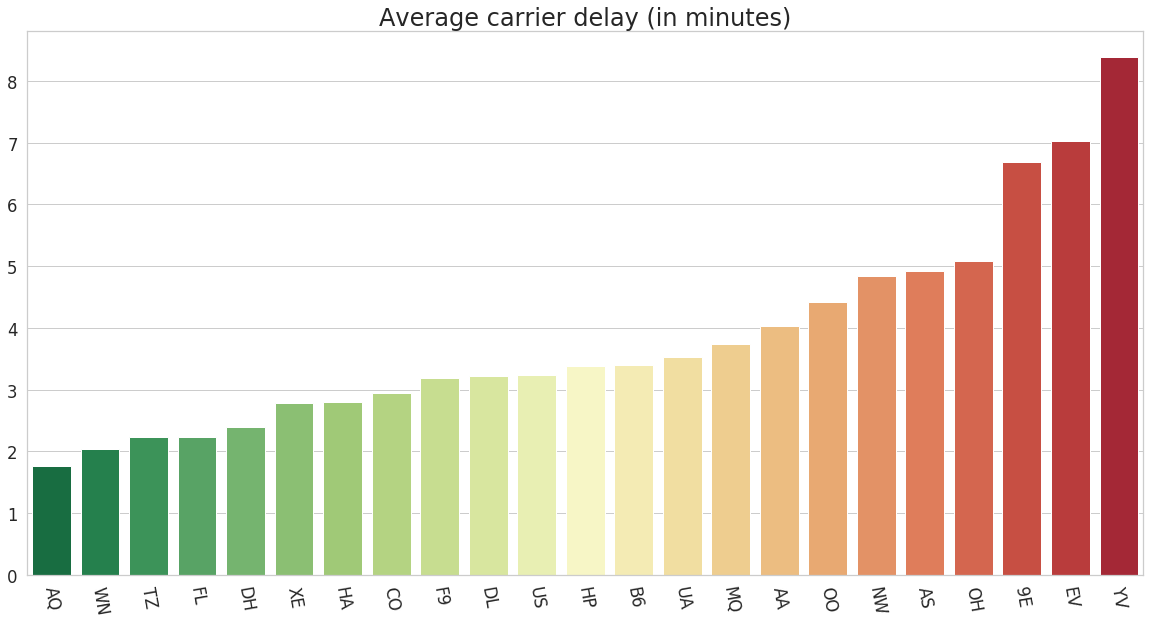

In [29]:
# plot average delay by carrier

values = [metric for carrier, metric in carr_list]
carriers = [carrier for carrier, metric in carr_list]
panda_dict = dict((c, v) for c, v in zip(carriers, values))

data = pd.DataFrame(data=panda_dict, index=range(24))

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.barplot(data=data, palette="RdYlGn_r")
ax.set_title('Average carrier delay (in minutes)')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=280)
ax.figure.set_size_inches(20, 10)

---
#### Is the carrier delay influenced by the number of flights operated by a carrier?

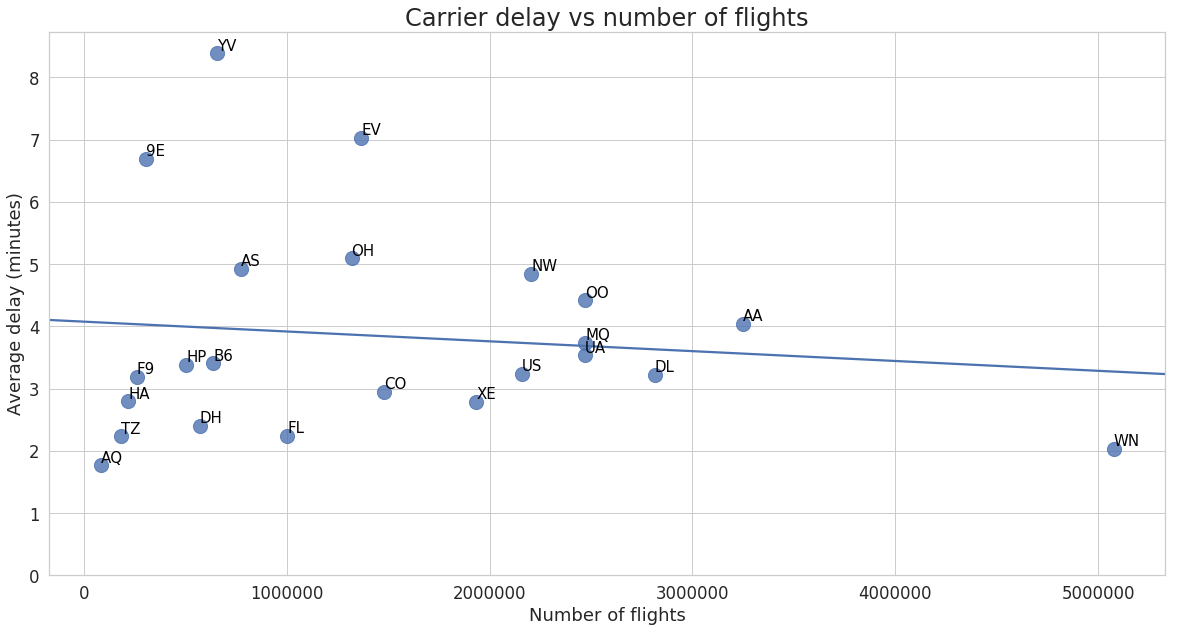

In [33]:
# plot average carrier delay vs number of flights

values = []
for carrier, avg_delay in carr_list:
    num_flights = carrier_num_flights[carrier]
    values.append((num_flights, avg_delay))

data = pd.DataFrame({'Number of flights': [num_flights for num_flights, _ in values],
                     'Average delay (minutes)': [delay for _, delay in values],
                     'labels': [carrier for carrier, _ in carr_list]})

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.regplot(data=data, x='Number of flights', y='Average delay (minutes)', scatter_kws={'s':200}, ci=None)
ax.set_title('Carrier delay vs number of flights')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
ax.figure.set_size_inches(20, 10)

# add annotations one by one with a loop
for line in range(0, data.shape[0]):
     ax.text(data['Number of flights'][line]+5, data['Average delay (minutes)'][line]+0.05, data.labels[line], horizontalalignment='left', size='small', color='black')

---
#### Is the carrier delay influenced by the carrier's average flight distance?

In [34]:
# compute average flight distance per carrier

carrier_distances = grouped_by_carrier.map(lambda t: (t[0], t[1]['Distance']))
total_distance = carrier_distances.reduceByKey(lambda a, b: a + b)
carrier_dist_res = total_distance.collect()

carrier_avg_dist = {}
for carrier, distance in carrier_dist_res:
    carrier_avg_dist[carrier] = distance / carrier_num_flights[carrier]

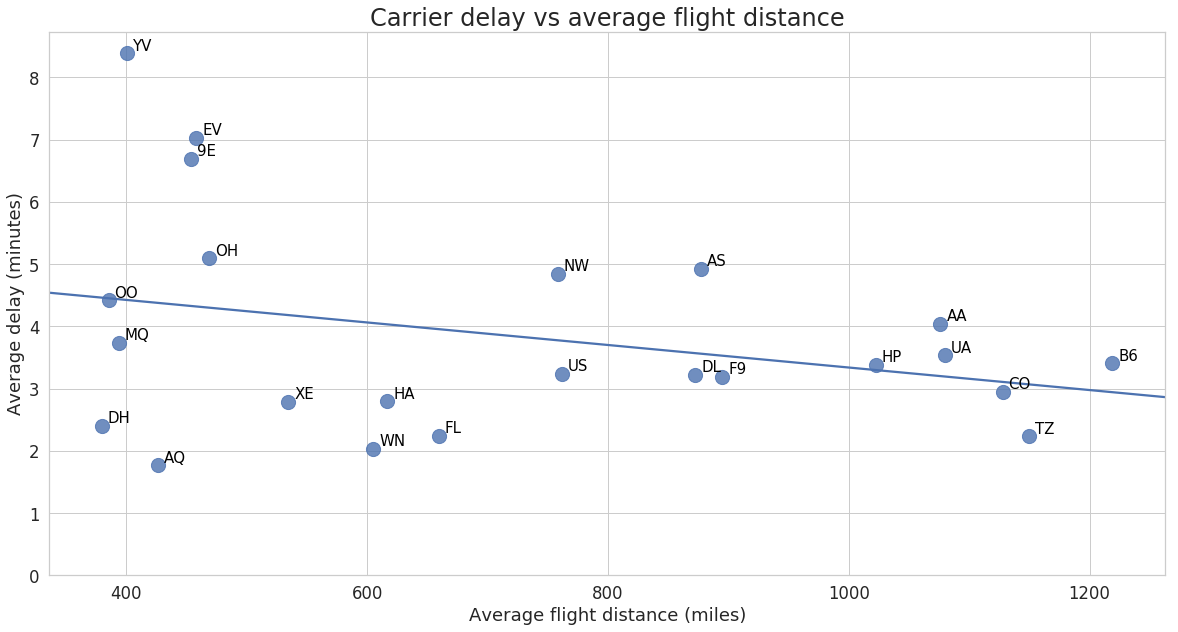

In [37]:
# plot average carrier delay vs average flight distance

values = []
for carrier, avg_delay in carr_list:
    avg_dist = carrier_avg_dist[carrier]
    values.append((avg_dist, avg_delay))

data = pd.DataFrame({'Average flight distance (miles)': [num_flights for num_flights, _ in values],
                     'Average delay (minutes)': [delay for _, delay in values],
                     'labels': [carrier for carrier, _ in carr_list]})

sns.set(font_scale=1.5, style="whitegrid")
ax = sns.regplot(data=data, x='Average flight distance (miles)', y='Average delay (minutes)', scatter_kws={'s':200}, ci=None)
ax.set_title('Carrier delay vs average flight distance')
ax.title.set_fontsize(24)
ax.set_ylim(0, None)
ax.figure.set_size_inches(20, 10)

# add annotations one by one with a loop
for line in range(0, data.shape[0]):
     ax.text(data['Average flight distance (miles)'][line]+5, data['Average delay (minutes)'][line]+0.05, data.labels[line], horizontalalignment='left', size='small', color='black')